In [1]:
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
import torch_geometric.nn as pyg_nn
import time
from torch_geometric.datasets import Entities
from torch_geometric.nn import FastRGCNConv, RGCNConv
from torch_geometric.utils import k_hop_subgraph
import matplotlib.pyplot as plt

# Download dataset

In [2]:
dataset="AIFB"
#Conv = FastRGCNConv
Conv = RGCNConv
dataset = Entities('data/Entities',dataset)
data = dataset[0]

In [3]:
print(data.num_nodes)

8285


# Define the Model 

In [4]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = RGCNConv(data.x.shape[1] if data.x is not None else data.num_nodes, 32, dataset.num_relations,num_bases=30)
        self.conv2 = RGCNConv(32, dataset.num_classes, dataset.num_relations,num_bases=30)

# type x=<class 'NoneType'>
# conv1 y.shape=torch.Size([8285, 32])
# conv2 y.shape=torch.Size([8285, 4])
    
    def forward(self,edge_index, edge_type,x=None):
        # print(f"type x={type(x)}")
        # if x is not None:
        #     print(f"input x.shape={x.shape}")
        y= F.relu(self.conv1(x, edge_index, edge_type))
        # print(f"conv1 y.shape={y.shape}")
        y = self.conv2(y, edge_index, edge_type)
        # print(f"conv2 y.shape={y.shape}")
        return F.log_softmax(y, dim=1)



In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')

else:
    device = torch.device('cpu')

model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0005)


In [6]:
device

device(type='cpu')

# Train and test the model then visualize the results

In [7]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.edge_index, data.edge_type,data.x)
    loss = F.nll_loss(out[data.train_idx], data.train_y)
    loss.backward()
    optimizer.step()
    return float(loss)

In [8]:
@torch.no_grad()
def test():
    model.eval()
    pred = model(data.edge_index, data.edge_type,data.x).argmax(dim=-1)
    train_acc = float((pred[data.train_idx] == data.train_y).float().mean())
    test_acc = float((pred[data.test_idx] == data.test_y).float().mean())
    return train_acc, test_acc

In [9]:
times = []
train_loss= []
accs_train= []
accs_test= []
for epoch in range(1, 20):
    start = time.time()
    loss = train()
    train_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f} 'f'Test: {test_acc:.4f}')
    accs_test.append(test_acc)
    accs_train.append(train_acc)
    train_loss.append(loss)
    
    times.append(time.time() - start)

/tmp/ipykernel_36420/1527250193.py:8: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  return float(loss)


Epoch: 01, Loss: 1.3847, Train: 0.9714 Test: 0.8611
Epoch: 02, Loss: 0.8633, Train: 0.9714 Test: 0.8611
Epoch: 03, Loss: 0.4598, Train: 0.9786 Test: 0.8889
Epoch: 04, Loss: 0.2364, Train: 0.9786 Test: 0.9444
Epoch: 05, Loss: 0.1297, Train: 0.9786 Test: 0.9444
Epoch: 06, Loss: 0.0799, Train: 0.9857 Test: 0.9444
Epoch: 07, Loss: 0.0546, Train: 0.9857 Test: 0.9444
Epoch: 08, Loss: 0.0388, Train: 0.9857 Test: 0.9444
Epoch: 09, Loss: 0.0267, Train: 0.9857 Test: 0.9444
Epoch: 10, Loss: 0.0171, Train: 1.0000 Test: 0.9444
Epoch: 11, Loss: 0.0103, Train: 1.0000 Test: 0.9444
Epoch: 12, Loss: 0.0064, Train: 1.0000 Test: 0.9444
Epoch: 13, Loss: 0.0045, Train: 1.0000 Test: 0.9444
Epoch: 14, Loss: 0.0035, Train: 1.0000 Test: 0.9444
Epoch: 15, Loss: 0.0029, Train: 1.0000 Test: 0.9444
Epoch: 16, Loss: 0.0025, Train: 1.0000 Test: 0.9444
Epoch: 17, Loss: 0.0020, Train: 1.0000 Test: 0.9444
Epoch: 18, Loss: 0.0017, Train: 1.0000 Test: 0.9444
Epoch: 19, Loss: 0.0013, Train: 1.0000 Test: 0.9444


In [10]:
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Median time per epoch: 2.3975s


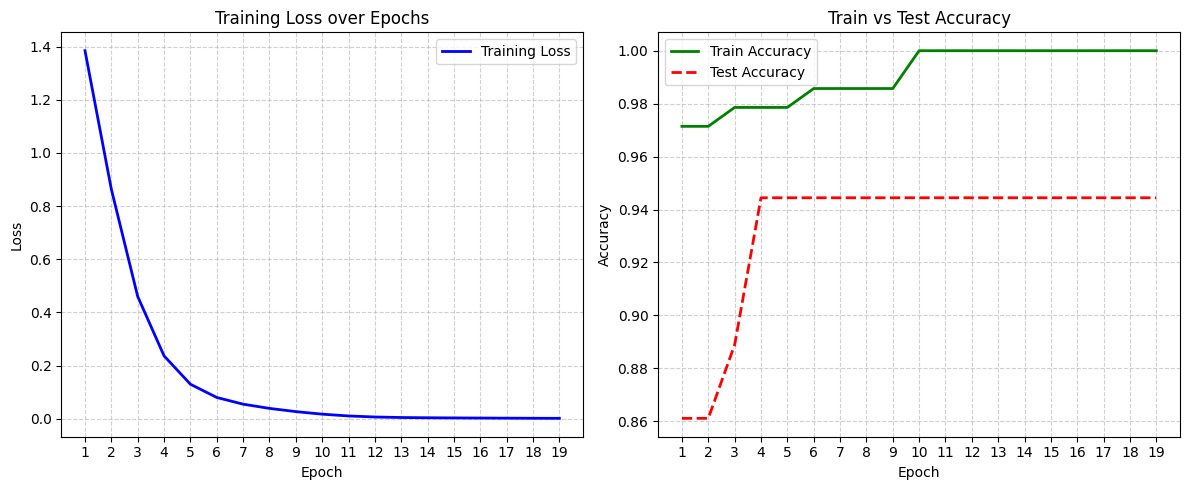

In [12]:
epochs = np.arange(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# --- Plot Training Loss ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', linewidth=2, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# --- Plot Train vs Test Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(epochs, accs_train, 'g-', linewidth=2, label='Train Accuracy')
plt.plot(epochs, accs_test, 'r--', linewidth=2, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')

plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('R-GCN training and testing results.png', dpi=300, bbox_inches='tight')
plt.show()


# Train using MLP as a baseline

In [13]:
#instead on NON of the data.x, use one of them a s an initialization
augment = "arange" # "arange" or "one-hot"
if augment == "arange":
    data.x = torch.arange(data.num_nodes, dtype=torch.float32)[:, None]
elif augment == "one-hot":
    data.x = torch.eye(data.num_nodes, dtype=torch.float32)
dataset.num_augmented_features = data.x.shape[1]

In [14]:
seed = 0
mlp_accuracies = []
mlp_loss = []

In [15]:
class MLPClassifier(nn.Module):
    def __init__(self, node_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.logits = nn.Linear(node_dim, num_classes)

    def forward(self, x):
        return self.logits(x)

    @torch.no_grad()
    def eval_accuracy(self, eval_x, eval_y):
        pred = self(eval_x).max(dim=1)[1]
        correct = pred.eq(eval_y).sum().item()
        total = eval_x.shape[0]
        return correct / total

def use_mlp(seed):
    # seed
    torch.manual_seed(seed)

    # model and optimizer
    mlp_model = MLPClassifier(dataset.num_augmented_features, dataset.num_classes)
    optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.01, weight_decay=5e-4)

    # train
    for epoch in range(100):
        mlp_model.train()
        feature, label = data.x[data.train_idx], data.train_y
        pred = mlp_model(feature)
        loss = F.cross_entropy(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # valid
        if (epoch + 1) % 5 == 0:
            accuracy = mlp_model.eval_accuracy(data.x[data.test_idx], data.test_y)
            print("Epoch: {}\t test accuracy: {}".format(epoch + 1, accuracy))
            mlp_accuracies.append(accuracy)
            mlp_loss.append(float(loss))

    # test
    accuracy = mlp_model.eval_accuracy(data.x[data.test_idx], data.test_y)
    return accuracy

In [16]:
accuracy = use_mlp(seed)
print("Model: MLP")
print("Mean: {}".format(np.mean(mlp_accuracies)))

Epoch: 5	 test accuracy: 0.08333333333333333
Epoch: 10	 test accuracy: 0.08333333333333333
Epoch: 15	 test accuracy: 0.08333333333333333
Epoch: 20	 test accuracy: 0.08333333333333333
Epoch: 25	 test accuracy: 0.08333333333333333
Epoch: 30	 test accuracy: 0.4166666666666667
Epoch: 35	 test accuracy: 0.4166666666666667
Epoch: 40	 test accuracy: 0.4166666666666667
Epoch: 45	 test accuracy: 0.4166666666666667
Epoch: 50	 test accuracy: 0.08333333333333333
Epoch: 55	 test accuracy: 0.08333333333333333
Epoch: 60	 test accuracy: 0.4166666666666667
Epoch: 65	 test accuracy: 0.08333333333333333
Epoch: 70	 test accuracy: 0.4166666666666667
Epoch: 75	 test accuracy: 0.4166666666666667
Epoch: 80	 test accuracy: 0.3333333333333333
Epoch: 85	 test accuracy: 0.3333333333333333
Epoch: 90	 test accuracy: 0.16666666666666666
Epoch: 95	 test accuracy: 0.4166666666666667
Epoch: 100	 test accuracy: 0.16666666666666666
Model: MLP
Mean: 0.25000000000000006


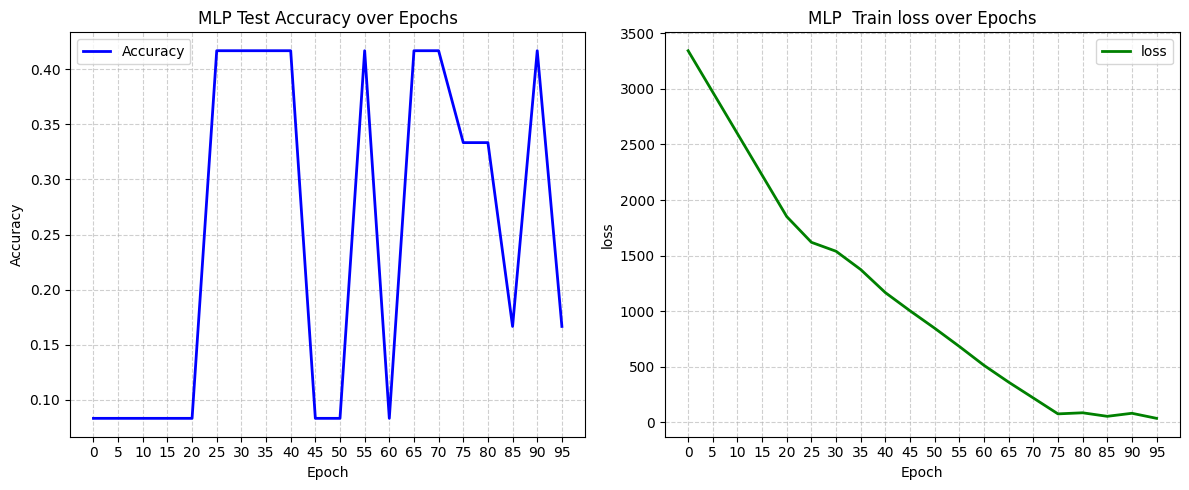

In [17]:
epochs = torch.arange(0, 100, 5)

plt.figure(figsize=(12, 5))

# --- Plot Training Loss ---
plt.subplot(1, 2, 1)
plt.plot(epochs, mlp_accuracies, 'b-', linewidth=2, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MLP Test Accuracy over Epochs')
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# --- Plot Train vs Test Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(epochs, mlp_loss, 'g-', linewidth=2, label='loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('MLP  Train loss over Epochs')

plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('MLP training and testing results.png', dpi=300, bbox_inches='tight')
plt.show()
